In [64]:
library(readr)
library(limma)
library(tximport)
library(edgeR)
library(ggplot2)
library(psych)
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/taejoon/miniconda3/lib/R/lib/libRblas.so

locale:
[1] C.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] psych_1.8.12    ggplot2_3.3.2   edgeR_3.28.1    limma_3.42.2   
[5] tximport_1.14.2 readr_1.3.1    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5       pillar_1.4.6     compiler_3.6.1   base64enc_0.1-3 
 [5] tools_3.6.1      digest_0.6.25    uuid_0.1-4       nlme_3.1-149    
 [9] jsonlite_1.7.0   evaluate_0.14    lifecycle_0.2.0  tibble_3.0.3    
[13] gtable_0.3.0     lattice_0.20-41  pkgconfig_2.0.3  rlang_0.4.7     
[17] IRdisplay_0.7.0  parallel_3.6.1   IRkernel_1.1.1   repr_1.1.0      
[21] withr_2.2.0      dplyr_1.0.2      generics_0.0.2   vctrs_0.3.2     
[25] hms_0.5.3        locfit_1.5-9.4   grid_3.6.1       tidyselect_1.1.0

In [115]:
# Prepare tx2gene
filename_tx2gene <- 'Bombina_orientalis.a2020_08.tx2gene'
#filename_tx2gene <- 'XENLA_XB201901_tx.HUMAN_ens95.tx2gene'
tx2gene <- read_tsv(filename_tx2gene, col_names=FALSE)
colnames(tx2gene) <- c('txName', 'geneName')
head(tx2gene)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_character()
)



txName,geneName
<chr>,<chr>
LGALS9B|t.TKLab201905_BOMORtx_F1-Ovary.017628,LGALS9B
C3|t.TKLab201905_BOMORtx_M1-Intestine.000368,C3
PDIA3|t.TKLab201905_BOMORtx_F1-Stomach.005613,PDIA3
MUC5B|t.TKLab201905_BOMORtx_M1-Stomach.000130,MUC5B
DYNC1H1|t.TKLab201905_BOMORtx_F1-VentralSkin.000021,DYNC1H1
AHNAK|t.TKLab201905_BOMORtx_M1-Heart.000018,AHNAK


In [116]:
# Load quantification data
#library(edgeR)

# Uncomment and change the filename below
filename_tbl <- 'BOMOR.conf'
#filename_tbl <- 'XENLA.conf'
file.exists(filename_tbl)

samples <- read.table(filename_tbl, header=TRUE)
files <- trimws(samples$Filename)
names(files) <- trimws(samples$SampleName)
all(file.exists(files))

txi <- tximport(files, type = "kallisto", tx2gene = tx2gene, countsFromAbundance = "lengthScaledTPM")
head(txi$counts)

[1] TRUE

[1] TRUE

Note: importing `abundance.h5` is typically faster than `abundance.tsv`

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 


summarizing abundance

summarizing counts

summarizing length



,PM0_3hr_1,PM0_3hr_2,PM0_9hr_1,PM0_9hr_2,PM100_3hr_1,PM100_3hr_2,PM100_9hr_1,PM100_9hr_2
A1BG,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
A1CF,63.00929,66.00183,109.84637,126.01727,50.93680,79.13257,103.04040,104.02459
A2LD1,32.37586,44.15193,59.64289,70.41108,46.77349,54.23700,48.90207,48.98004
A2M,170.06311,211.99358,213.14772,357.12123,176.33235,287.49225,293.33937,311.20875
A2ML1,176.06503,228.99233,581.68749,443.15070,194.26873,248.28094,396.45754,334.22245
A4GNT,65.99539,82.00704,67.07940,75.99528,75.09636,113.79434,63.97639,63.98758


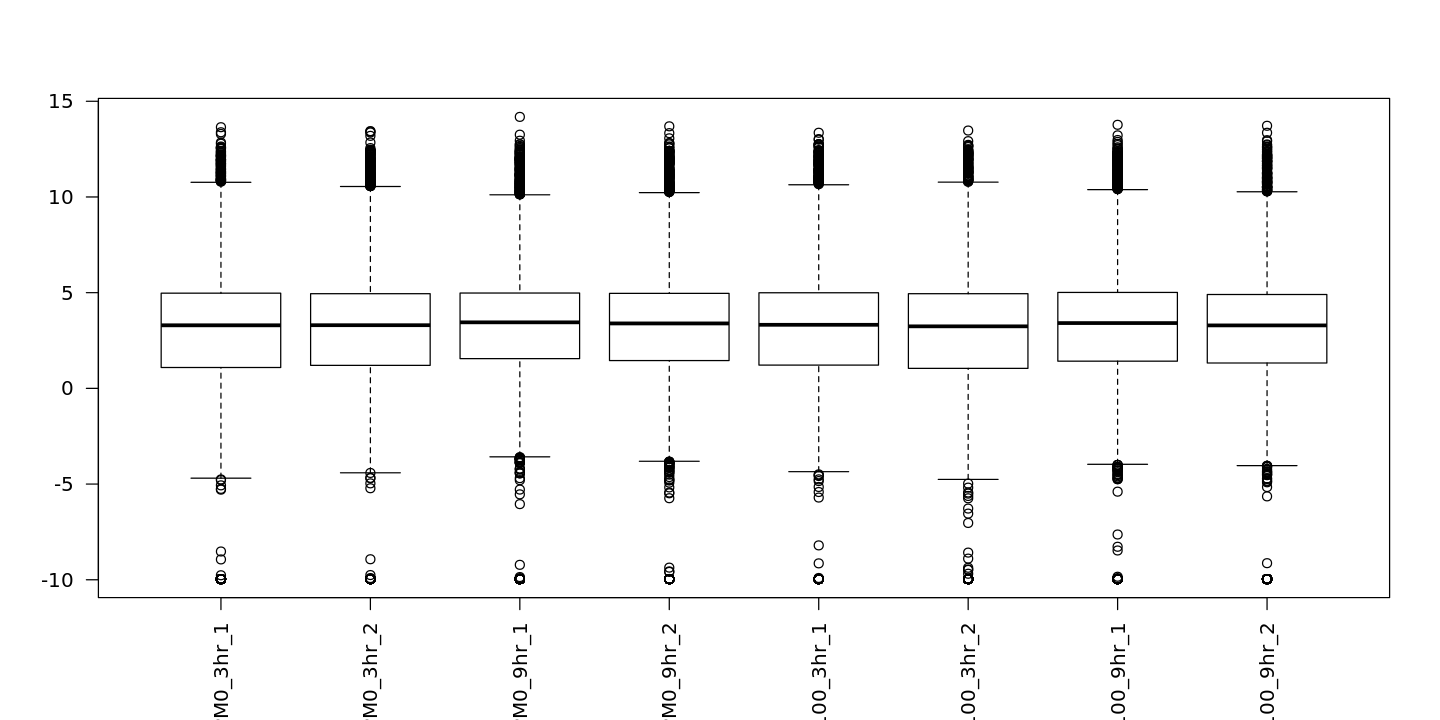

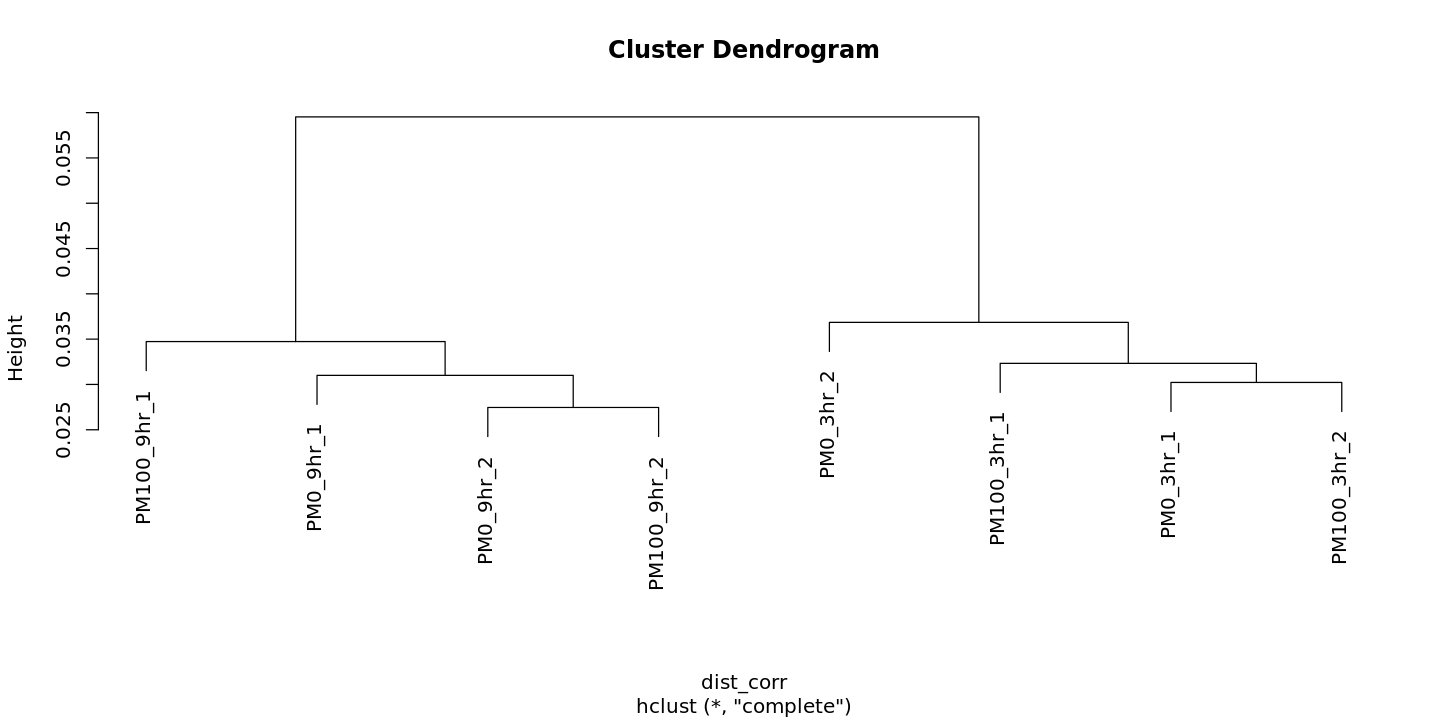

In [117]:
# Boxplot and hierarchical clustering with raw data
options(repr.plot.width=12, repr.plot.height=6)

boxplot(log(txi$abundance+0.001, base=2), las=2)
dist_corr <- dist(1-cor(as.matrix(txi$abundance), method='spearman'))
plot(hclust(dist_corr))

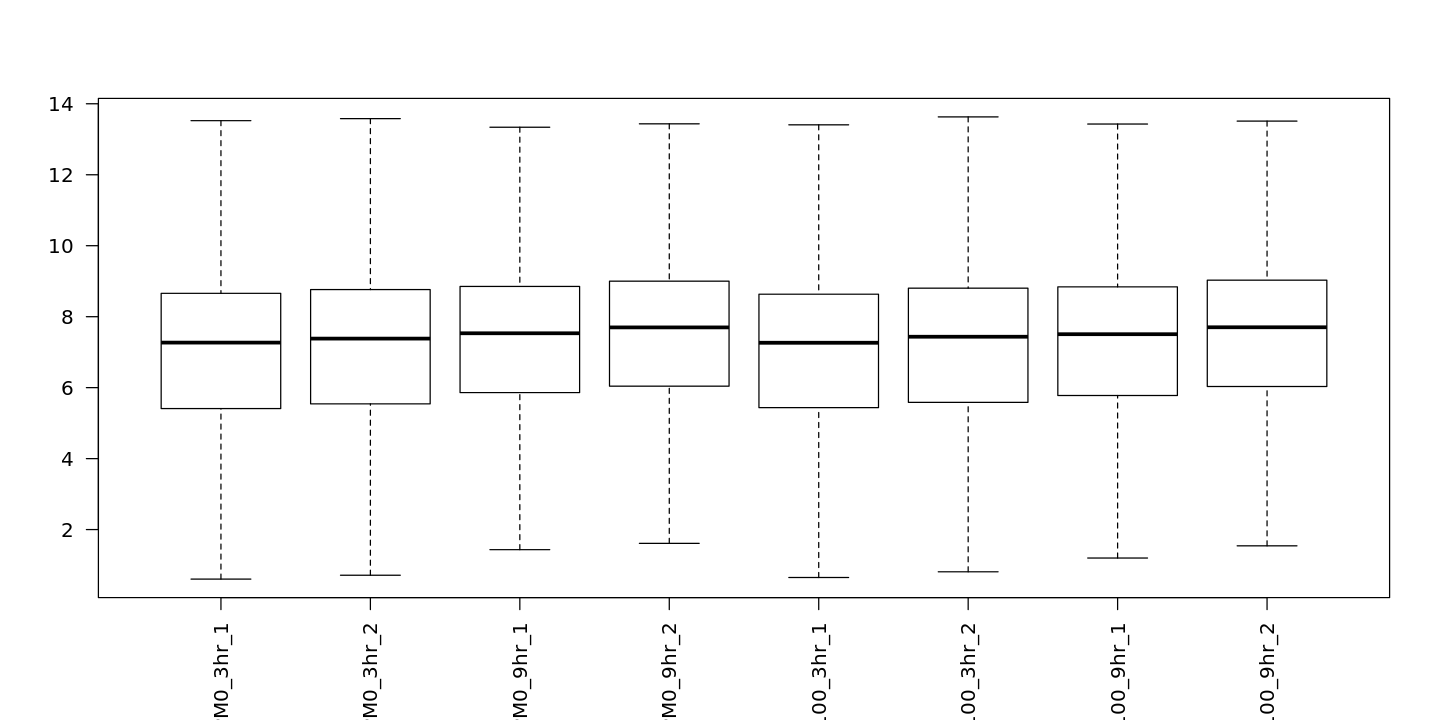

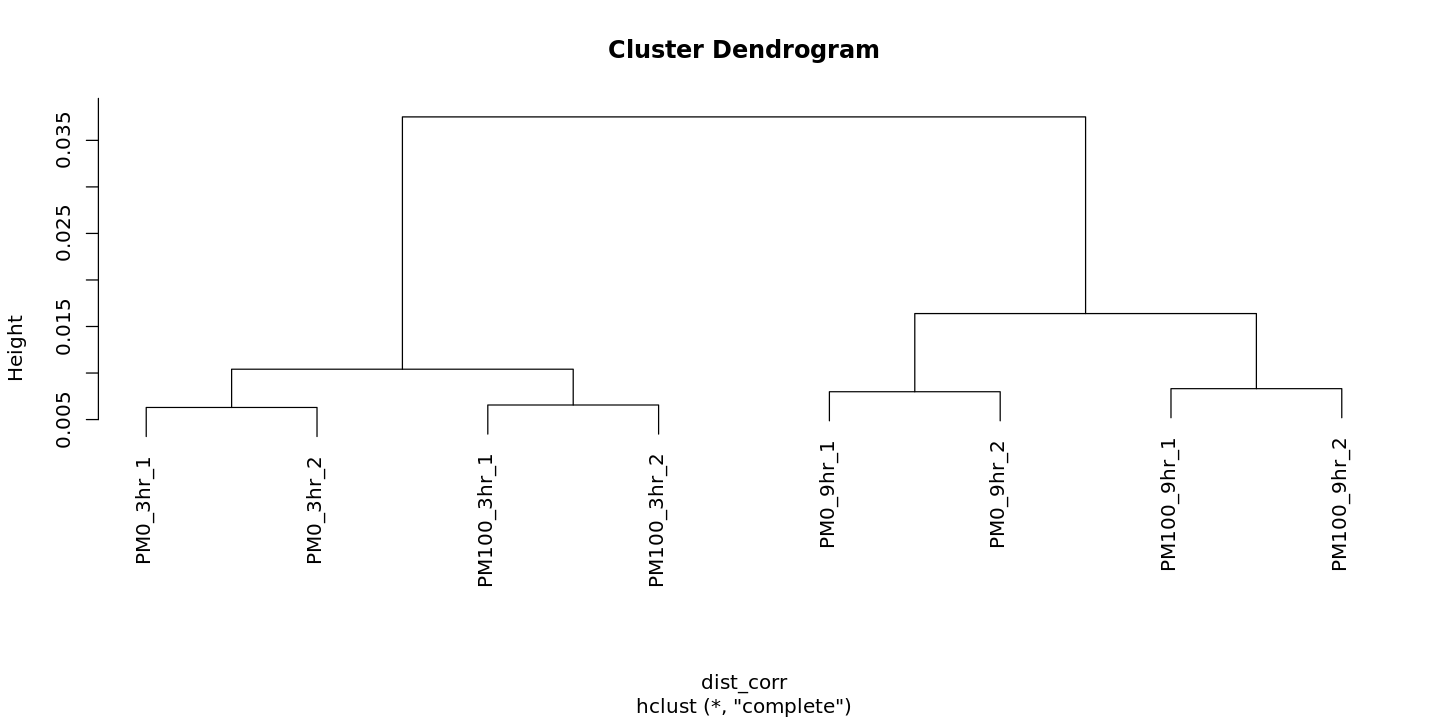

In [118]:
# Boxplot and hierarchical clustering with filtered data
options(repr.plot.width=12, repr.plot.height=6)

boxplot(log(as.matrix(y)+0.001, base=2), las=2, outline=FALSE)
dist_corr <- dist(1-cor(as.matrix(y), method='spearman'))
plot(hclust(dist_corr))

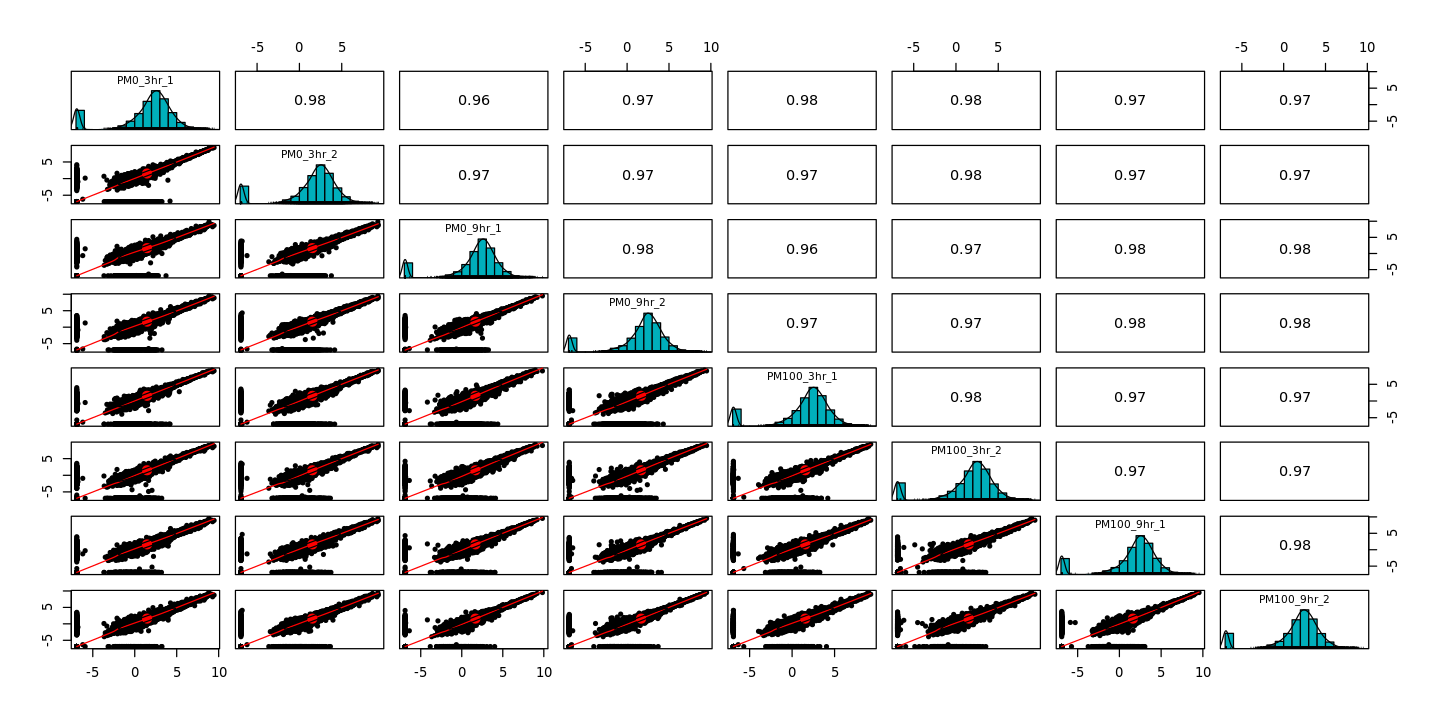

In [119]:
# Pair plot
library(psych)
pairs.panels(log(txi$abundance+0.001),
             method = "spearman", # correlation method
             hist.col = "#00AFBB",
             density = TRUE,  # show density plots
             ellipses = TRUE # show correlation ellipses
             )

In [120]:
groups <- gsub('_\\d+$','',samples$GroupName)
groups
batches <- gsub('^\\w+_','',samples$SampleName)
batches

# Creating a DGEList object for use in edgeR.
y <- DGEList(counts=txi$counts, group=groups)
design <- model.matrix(~0+groups)
colnames(design) <- gsub('groups', '', colnames(design))
design

v <- voom(y, design)


fit_lm <- lmFit(v, design)
contrast_mat <- makeContrasts(PM100_9hr-PM100_3hr, PM0_9hr-PM0_3hr, PM100_9hr-PM0_9hr, PM100_3hr-PM0_3hr, levels=design)

fit_c <- contrasts.fit(fit_lm, contrast_mat)
fit_c <- eBayes(fit_c)

[1] "PM0_3hr"   "PM0_3hr"   "PM0_9hr"   "PM0_9hr"   "PM100_3hr" "PM100_3hr"
[7] "PM100_9hr" "PM100_9hr"

[1] "1" "2" "1" "2" "1" "2" "1" "2"

,PM0_3hr,PM0_9hr,PM100_3hr,PM100_9hr
1,1,0,0,0
2,1,0,0,0
3,0,1,0,0
4,0,1,0,0
5,0,0,1,0
6,0,0,1,0
7,0,0,0,1
8,0,0,0,1


In [124]:
#contrast_mat <- makeContrasts(PM100_9hr-PM100_3hr, PM0_9hr-PM0_3hr, PM100_9hr-PM0_9hr, PM100_3hr-PM0_3hr, levels=design)

list_PM100_9vs3 <- topTable(fit_c, coef=1, confint=TRUE, n=Inf, adjust="BH")
list_PM0_9vs3 <- topTable(fit_c, coef=2, confint=TRUE, n=Inf, adjust="BH")
list_PM100vs0_9 <- topTable(fit_c, coef=3, confint=TRUE, n=Inf, adjust="BH")
list_PM100vs0_3 <- topTable(fit_c, coef=4, confint=TRUE, n=Inf, adjust="BH")

head(list_PM100_9vs3)
head(list_PM0_9vs3)

total_list <- list_PM0_9vs3
filename_out <- 'BOMOR_PM0_9vs3hr'

DE_keep <- total_list$adj.P.Val <= 0.05 & abs(total_list$logFC) >= 1
DE_list <- total_list[DE_keep,]

filename_all <- paste(filename_out, 'limma_all.txt', sep='.')
write.table(total_list, filename_all, sep='\t')

filename_DE <- paste(filename_out, 'limma_DE.txt', sep='.')
write.table(DE_list, filename_DE, sep='\t')

#logCPM <- cpm(tbl_count, log=TRUE)
filename_cpm <- paste(filename_out, 'abundance.txt', sep='.')
write.table(txi$abundance, filename_cpm, sep='\t')


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GON4L,-1.5151633,-1.7766846,-1.2536420,4.840147,-13.32505,8.350895e-07,0.005359999,5.890706
SLC1A5,-1.1065658,-1.3145386,-0.8985931,5.643191,-12.23734,1.619068e-06,0.005359999,5.663138
HES1,-1.4420762,-1.7261017,-1.1580507,6.848332,-11.67743,2.325242e-06,0.005359999,5.475957
CNBP,-0.8690609,-1.0439987,-0.6941230,8.530478,-11.42570,2.750221e-06,0.005359999,5.366937
SLC30A7,-1.5718607,-1.8836760,-1.2600454,5.889460,-11.59399,2.457385e-06,0.005359999,5.317783
NDRG1,1.0621462,0.8400795,1.2842128,7.044220,11.00062,3.679518e-06,0.005359999,5.060486


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PGK1,1.1059984,0.9107609,1.301236,7.639816,13.02890,9.950077e-07,0.006737032,6.361630
MYBPC3,1.3044404,1.0548892,1.553991,7.805902,12.02212,1.857407e-06,0.006737032,5.765101
GON4L,-1.3153391,-1.5631234,-1.067555,4.840147,-12.20900,1.648405e-06,0.006737032,5.692414
NDRG1,1.1686256,0.9424136,1.394838,7.044220,11.88164,2.034049e-06,0.006737032,5.666752
CNBP,-0.9041002,-1.0815554,-0.726645,8.530478,-11.71775,2.264244e-06,0.006737032,5.574069
TNNI3,0.9772010,0.7750932,1.179309,7.343147,11.12032,3.386556e-06,0.007014124,5.176383
